In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

In [26]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['photoC_TOT_zint','zoo1C','zoo2C','zoo3C','zoo4C','diatC','x_graze_zoo3_zint','x_graze_zoo4_zint','photoC_diat_zint','photoC_sp_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [27]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004
photoC_TOT_zint
zoo1C
zoo2C
zoo3C
zoo4C
diatC
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_diat_zint
photoC_sp_zint
CPU times: user 6 s, sys: 1.09 s, total: 7.09 s
Wall time: 8.76 s


In [28]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['HTLfood_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.x_graze_zoo3_zint / ds.photoC_TOT_zint
ds['zratio'] = tmp

In [29]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1958,1958+tlen,1)
years[2:61]

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

### plotting function (helps with South Pole stereographic map)

In [30]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [31]:
lons_norm=np.full((384, 320), np.nan)

lons_norm_firstpart = lons.where(lons<=180.)
lons_norm_secpart = lons.where(lons>180.) - 360.

lons_norm_firstpart = np.asarray(lons_norm_firstpart)
lons_norm_secpart = np.asarray(lons_norm_secpart)

lons_norm[~np.isnan(lons_norm_firstpart)] = lons_norm_firstpart[~np.isnan(lons_norm_firstpart)]
lons_norm[~np.isnan(lons_norm_secpart)] = lons_norm_secpart[~np.isnan(lons_norm_secpart)]

lons_norm=xr.DataArray(lons_norm)
lons_norm=lons_norm.rename({'dim_0':'nlat'})
lons_norm=lons_norm.rename({'dim_1':'nlon'})

In [32]:
variables = ['photoC_TOT_zint','zoo1C_zint','zoo2C_zint','zoo3C_zint','zoo4C_zint','diatC_zint','x_graze_zoo3_zint','x_graze_zoo4_zint','photoC_diat_zint','photoC_sp_zint']

In [33]:
ds['zoo4_growthrate'] = (ds.x_graze_zoo4_zint * 864.) / ds.zoo4C_zint
ds['zoo3_growthrate'] = (ds.x_graze_zoo3_zint * 864.) / ds.zoo3C_zint

In [34]:
ds['zoo4_turnover'] = 1./ds['zoo4_growthrate']
ds['zoo3_turnover'] = 1./ds['zoo3_growthrate']

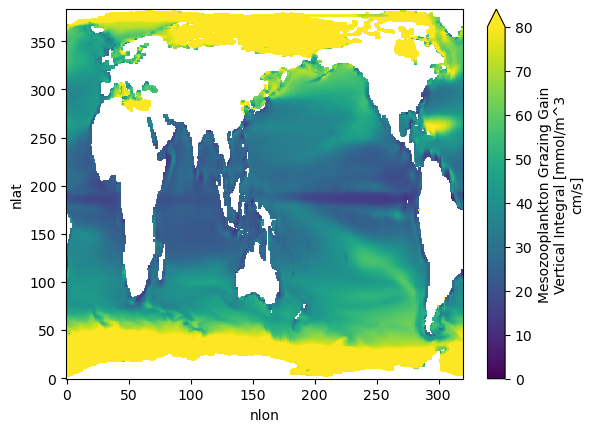

In [35]:
ds['zoo3_turnover'].mean(dim='time').plot(vmin=0,vmax=80)

In [36]:
ds['zoo4C_zint'] = ds.zoo4C_zint.where(ds.zoo1C.isel(z_t_150m=0)>-10.)

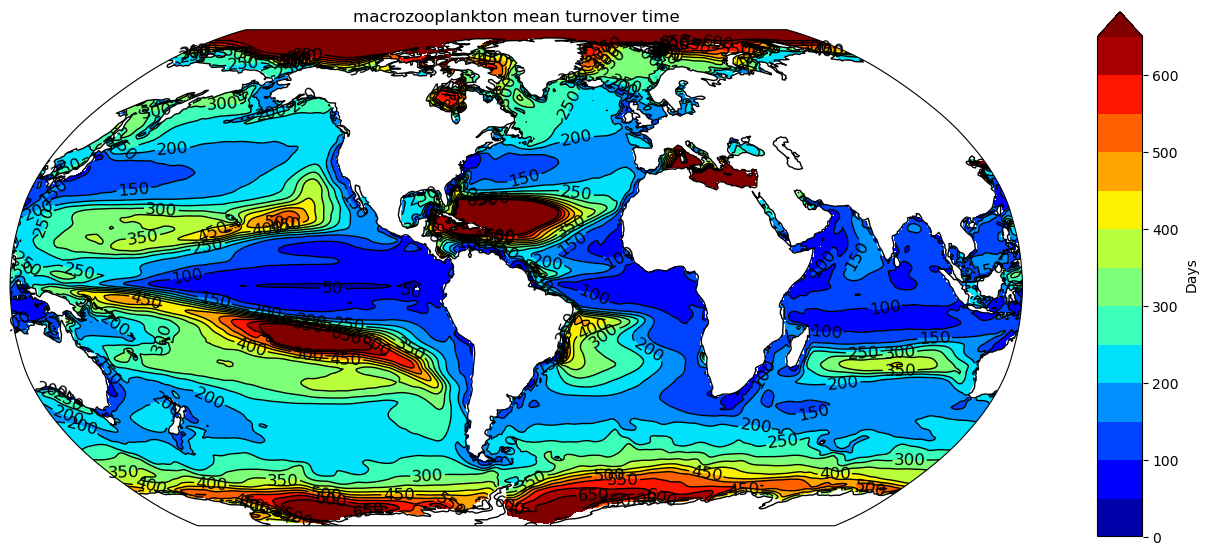

In [37]:
fig = plt.figure(figsize=(15,7.5))
contour_specs = {'levels': np.arange(0,700,50)}

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))

#### zoo1
ax.set_title('macrozooplankton mean turnover time', fontsize=12)

lon,lat,field = adjust_pop_grid(lons,lats,ds.zoo4_turnover.mean(dim='time'))
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Days');

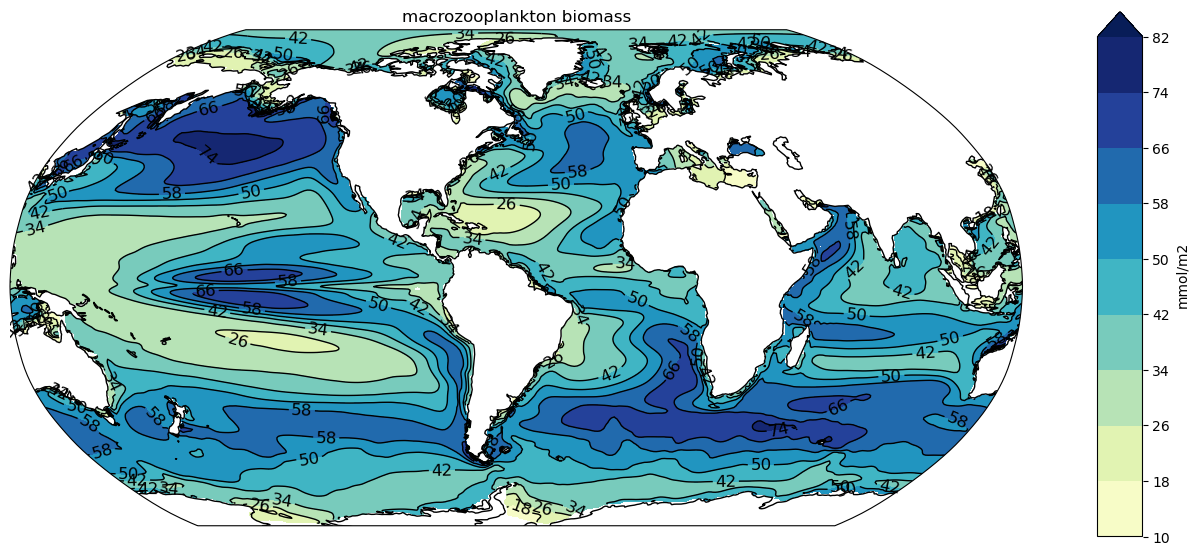

In [45]:
fig = plt.figure(figsize=(15,7.5))
contour_specs = {'levels': np.arange(10,90,8)}

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))

#### zoo1
ax.set_title('macrozooplankton biomass', fontsize=12)

lon,lat,field = adjust_pop_grid(lons,lats,ds.zoo4C_zint.mean(dim='time'))
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='YlGnBu',extend='max',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='mmol/m2');

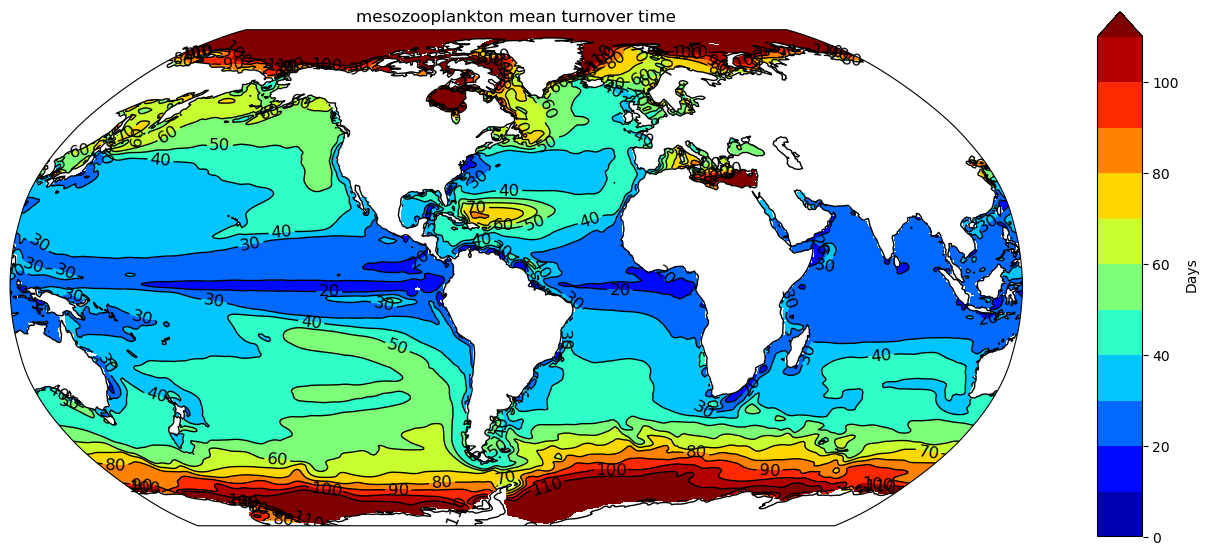

In [40]:
fig = plt.figure(figsize=(15,7.5))
contour_specs = {'levels': np.arange(0,120,10)}

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))

#### zoo1
ax.set_title('mesozooplankton mean turnover time', fontsize=12)

lon,lat,field = adjust_pop_grid(lons,lats,ds.zoo3_turnover.mean(dim='time'))
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Days');

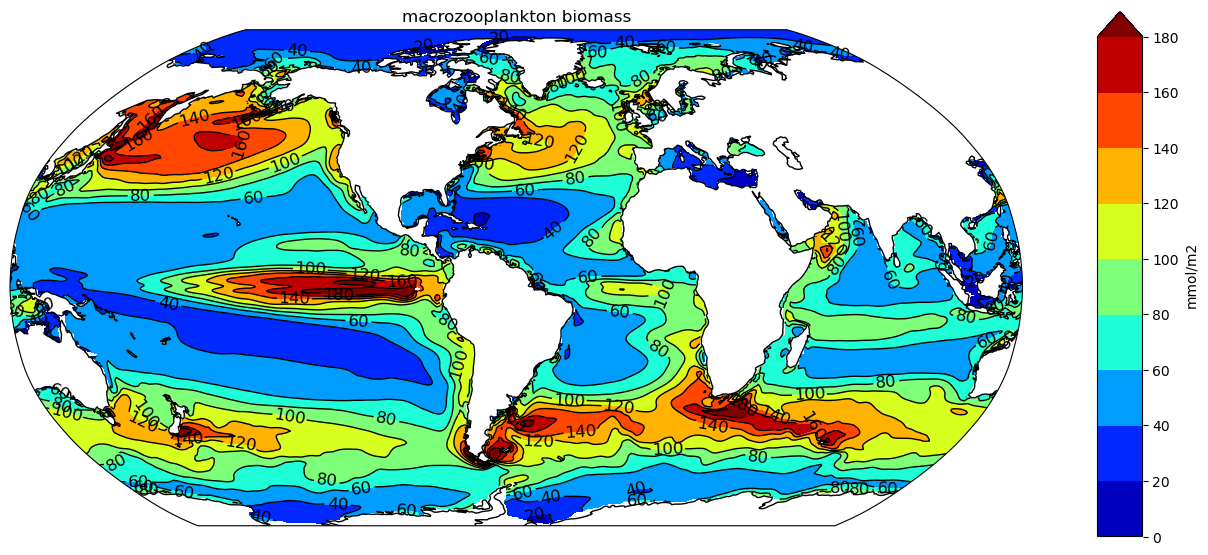

In [43]:
fig = plt.figure(figsize=(15,7.5))
contour_specs = {'levels': np.arange(0,200,20)}

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))

#### zoo1
ax.set_title('macrozooplankton biomass', fontsize=12)
ds['zoo3C_zint'] = ds.zoo3C_zint.where(ds.zoo1C.isel(z_t_150m=0)>-10.)
lon,lat,field = adjust_pop_grid(lons,lats,ds.zoo3C_zint.mean(dim='time'))
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='mmol/m2');